### Case Study

FTX allows customers to trade based on the size of Move for Bitcoin. If we can determine a model, which can forecast better than 50/50 accuracy, whether or not Bitcoins move will likely be above it's average, then we have an edge.

The catch is, how to predict whether future volatility will be above or below the rolling average (assuming that the rolling average is where the market adjusts to). Regardless, this will be a significant challenge and we will need state-of-the-art methods, whilst making sure we do not overfit.

### Imports

In [2]:
import numpy as np
import pandas as pd
from stratmanager import StrategyManager
import sklearn.mixture as mix
from ta.momentum import RSIIndicator
import matplotlib.pyplot as plt
import yfinance

### Data Extraction and Returns Overview

In [3]:
# Extract Data
start_date = "2010-01-1"
end_date = "2022-06-1"
    
symbol = "TATAMOTORS.NS"
strat_mgr = StrategyManager(symbol, start_date, end_date)
df = strat_mgr.df.copy()
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume,Returns,Range,Bench_C_Rets
Date,,,,,,,,
2010-01-05,151.945598,156.522508,143.505207,150.472473,23669317,-0.017424,0.090710,-0.008167
2010-01-06,151.890020,152.575629,149.184652,150.704102,14990820,0.001539,0.022730,-0.005175
2010-01-07,150.926466,151.630607,144.533627,145.552780,22722030,-0.034182,0.049103,-0.033675
2010-01-08,146.386630,149.129064,145.469399,146.349579,16495776,0.005474,0.025158,-0.017068
2010-01-11,148.054303,148.054303,144.950532,146.414398,11776347,0.000443,0.021413,-0.019308


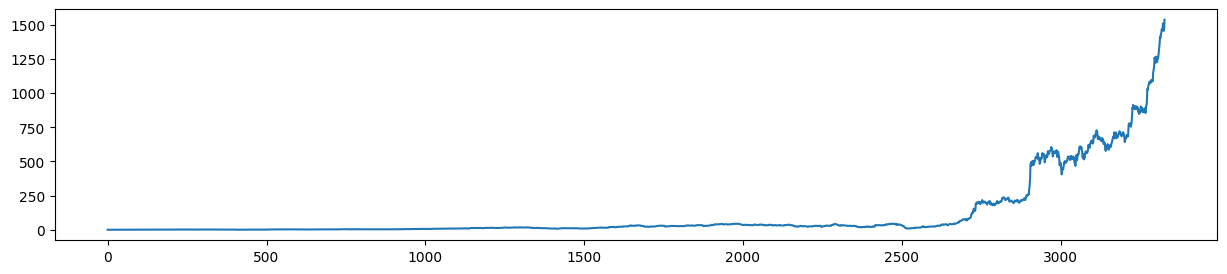

In [4]:
# Benchmark Returns Profile
fig = plt.figure(figsize = (15, 3))
plt.plot(df["Bench_C_Rets"].values)
plt.show()

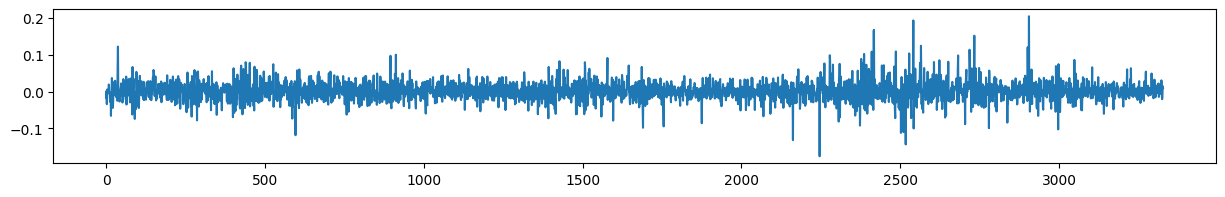

In [5]:
# Benchmark Returns Profile
fig = plt.figure(figsize = (15, 2))
plt.plot(df["Returns"].values)
plt.show()

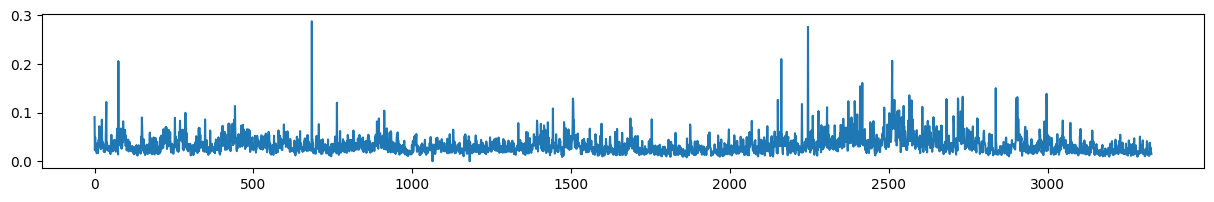

In [6]:
# Benchmark Range Profile
fig = plt.figure(figsize = (15, 2))
plt.plot(df["Range"].values)
plt.show()

### Feature Engineering - Feature Expansion

In [7]:
# Create a copy
df_fe = df.copy()

##### Indicators

In [8]:
# Add RSI
rsi = RSIIndicator(close=df_fe["Close"], window=14).rsi()
df_fe["RSI"] = rsi
df_fe["RSI_Ret"] = df_fe["RSI"] / df_fe["RSI"].shift(1)

In [9]:
# Add Moving Average
df_fe["MA_12"] = df_fe["Close"].rolling(window=12).mean()
df_fe["MA_21"] = df_fe["Close"].rolling(window=21).mean()

In [10]:
# Day of Week
df_fe["DOW"] = df_fe.index.dayofweek

In [11]:
# Rolling Cumulative Returns
df_fe["Roll_Rets"] = df_fe["Returns"].rolling(window=30).sum()

In [12]:
# Rolling Cumulative Range
df_fe["Avg_Range"] = df_fe["Range"].rolling(window=30).mean()

##### Time Intervals

In [13]:
# Add Time Intervals
t_steps = [1, 2]
t_features = ["Returns", "Range", "RSI_Ret"]
for ts in t_steps:
    for tf in t_features:
        df_fe[f"{tf}_T{ts}"] = df_fe[tf].shift(ts)

In [15]:
# Show DataFrame
df_fe.tail(3)

,Open,High,Low,Close,Volume,Returns,Range,Bench_C_Rets,RSI,RSI_Ret,...,MA_21,DOW,Roll_Rets,Avg_Range,Returns_T1,Range_T1,RSI_Ret_T1,Returns_T2,Range_T2,RSI_Ret_T2
Date,,,,,,,,,,,,,,,,,,,,,
2023-06-23,570.0,571.150024,557.700012,559.650024,9362695,-0.017037,0.024117,1457.274242,56.813492,0.895123,...,554.411909,4,0.084757,0.021768,-0.020726,0.029039,0.864846,-0.003172,0.019843,0.977722
2023-06-26,560.0,569.000000,557.799988,567.849976,6986621,0.014652,0.020079,1484.243066,60.577488,1.066252,...,556.764288,0,0.070531,0.021437,-0.017037,0.024117,0.895123,-0.020726,0.029039,0.864846
2023-06-27,570.0,576.900024,568.450012,573.099976,9404450,0.009245,0.014865,1537.861952,62.812262,1.036891,...,559.223810,1,0.098049,0.020834,0.014652,0.020079,1.066252,-0.017037,0.024117,0.895123


### Feature Engineering - Feature Scaling

In [16]:
# Correct for Stationarity
df_fs = df_fe.copy()
df_fs[["Open", "High", "Low", "Volume"]] = df_fs[["Open", "High", "Low", "Volume"]].pct_change()
df_fs

,Open,High,Low,Close,Volume,Returns,Range,Bench_C_Rets,RSI,RSI_Ret,...,MA_21,DOW,Roll_Rets,Avg_Range,Returns_T1,Range_T1,RSI_Ret_T1,Returns_T2,Range_T2,RSI_Ret_T2
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-05,NaN,NaN,NaN,150.472473,NaN,-0.017424,0.090710,-0.008167,NaN,NaN,...,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,-0.000366,-0.025216,0.039577,150.704102,-0.366656,0.001539,0.022730,-0.005175,NaN,NaN,...,NaN,2,NaN,NaN,-0.017424,0.090710,NaN,NaN,NaN,NaN
2010-01-07,-0.006344,-0.006194,-0.031176,145.552780,0.515730,-0.034182,0.049103,-0.033675,NaN,NaN,...,NaN,3,NaN,NaN,0.001539,0.022730,NaN,-0.017424,0.090710,NaN
2010-01-08,-0.030080,-0.016498,0.006474,146.349579,-0.274018,0.005474,0.025158,-0.017068,NaN,NaN,...,NaN,4,NaN,NaN,-0.034182,0.049103,NaN,0.001539,0.022730,NaN
2010-01-11,0.011392,-0.007207,-0.003567,146.414398,-0.286099,0.000443,0.021413,-0.019308,NaN,NaN,...,NaN,0,NaN,NaN,0.005474,0.025158,NaN,-0.034182,0.049103,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-21,0.033389,0.003339,0.021333,581.400024,-0.493976,-0.003172,0.019843,1511.274657,73.388832,0.977722,...,549.938099,2,0.135145,0.021233,0.030386,0.038133,1.088573,-0.006581,0.015952,0.950421
2023-06-22,-0.001624,-0.002048,-0.010966,569.349976,0.227725,-0.020726,0.029039,1481.622151,63.470009,0.864846,...,552.278573,3,0.110297,0.021630,-0.003172,0.019843,0.977722,0.030386,0.038133,1.088573
2023-06-23,-0.023973,-0.023174,-0.018479,559.650024,-0.166217,-0.017037,0.024117,1457.274242,56.813492,0.895123,...,554.411909,4,0.084757,0.021768,-0.020726,0.029039,0.864846,-0.003172,0.019843,0.977722


### Assess Data for ML Readiness

In [17]:
# Check for NaN
df_fs.dropna(inplace=True)
print(df_fs.isnull().values.any())

False


In [18]:
# Check for Inf values
dfobj = df_fs.isin([np.inf, -np.inf])
count = np.isinf(dfobj).values.sum()
count

0

In [19]:
# Check for non-numerical objects
df_fs.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3299 entries, 2010-02-17 to 2023-06-27
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          3299 non-null   float64
 1   High          3299 non-null   float64
 2   Low           3299 non-null   float64
 3   Close         3299 non-null   float64
 4   Volume        3299 non-null   float64
 5   Returns       3299 non-null   float64
 6   Range         3299 non-null   float64
 7   Bench_C_Rets  3299 non-null   float64
 8   RSI           3299 non-null   float64
 9   RSI_Ret       3299 non-null   float64
 10  MA_12         3299 non-null   float64
 11  MA_21         3299 non-null   float64
 12  DOW           3299 non-null   int32  
 13  Roll_Rets     3299 non-null   float64
 14  Avg_Range     3299 non-null   float64
 15  Returns_T1    3299 non-null   float64
 16  Range_T1      3299 non-null   float64
 17  RSI_Ret_T1    3299 non-null   float64
 18  Returns_T2

In [20]:
# Describe DataFrame
df_fs.describe()

,Open,High,Low,Close,Volume,Returns,Range,Bench_C_Rets,RSI,RSI_Ret,...,MA_21,DOW,Roll_Rets,Avg_Range,Returns_T1,Range_T1,RSI_Ret_T1,Returns_T2,Range_T2,RSI_Ret_T2
count,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,...,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000
mean,0.000791,0.000723,0.000791,320.353088,inf,0.000794,0.033446,116.279559,51.214742,1.004938,...,319.026612,1.992725,0.022865,0.033537,0.000800,0.033452,1.005006,0.000793,0.033456,1.004976
std,0.026012,0.023589,0.025828,130.612105,NaN,0.026334,0.019574,248.652074,12.705941,0.099814,...,129.483729,1.414409,0.164590,0.009680,0.026338,0.019572,0.099912,0.026338,0.019570,0.099909
min,-0.131140,-0.110270,-0.278927,65.300003,-1.000000,-0.175827,0.000000,-0.202847,12.647159,0.513816,...,71.804762,0.000000,-0.945828,0.018395,-0.175827,0.000000,0.513816,-0.175827,0.000000,0.513816
25%,-0.013622,-0.011262,-0.011561,197.510612,-0.256249,-0.013140,0.021231,3.765650,42.469590,0.944174,...,195.306766,1.000000,-0.071386,0.026634,-0.013140,0.021234,0.944174,-0.013140,0.021236,0.944174
50%,0.000000,-0.000431,0.001552,313.100006,-0.023368,0.000162,0.029044,20.090977,51.088707,1.000517,...,312.009527,2.000000,0.024285,0.030971,0.000162,0.029046,1.000517,0.000115,0.029060,1.000511
75%,0.014320,0.011532,0.013425,431.899994,0.300635,0.013762,0.039961,38.075401,60.525233,1.052889,...,428.360849,3.000000,0.112385,0.038708,0.013799,0.039961,1.052914,0.013762,0.039961,1.052889
max,0.155313,0.202318,0.234906,597.892273,inf,0.204467,0.287309,1537.861952,91.791621,1.667627,...,572.225691,6.000000,0.734200,0.079958,0.204467,0.287309,1.667627,0.204467,0.287309,1.667627


### Save Data

In [21]:
# Save DataFrame
df_fs.to_csv(f"data/{symbol}.csv")